<a href="https://colab.research.google.com/github/ravellys/NLP_coursera/blob/main/Semana02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
#import dataser
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [ ]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

# função para extrair dados de sentence e label do data_set imdb
def sentences_labels(data):
  sentences = []
  labels = []
  for s, l in data:
    sentences.append(s.numpy().decode('utf8'))
    labels.append(l.numpy())
  return sentences, np.array(labels)

training_sentences, training_labels_final = sentences_labels(train_data)
testing_sentences, testing_labels_final = sentences_labels(test_data)

In [ ]:
print(f"está é uma sentença:{training_sentences[0]}")
print(f"está é sua label: {training_labels_final[0]}")

está é uma sentença:This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
está é sua label: 0


In [ ]:
# parametros iniciais
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<00v>"

In [ ]:
# preparação dos dados / tranformando sentenças em vetores
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def padded_data(vocab_size, training_sentences, testing_sentences, max_length, trunc_type):
  tokenizer = Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(training_sentences)
  word_index = tokenizer.word_index

  sequences = tokenizer.texts_to_sequences(training_sentences)
  padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

  return padded, testing_padded, tokenizer

padded, testing_padded, tokenizer = padded_data(vocab_size, training_sentences, testing_sentences, max_length, trunc_type)

In [ ]:
# comparação de dados reais e dados processados

reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you into a big arm chair and for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no to cross no dangerous waters just a warm and witty through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')                           
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
model.fit(x=padded,
          y=training_labels_final,
          epochs=num_epochs,
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.5386 - accuracy: 0.7370 - val_loss: 0.3668 - val_accuracy: 0.8532
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3011 - accuracy: 0.8862 - val_loss: 0.3357 - val_accuracy: 0.8586
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1993 - accuracy: 0.9360 - val_loss: 0.3660 - val_accuracy: 0.8491
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1200 - accuracy: 0.9701 - val_loss: 0.4019 - val_accuracy: 0.8434
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0670 - accuracy: 0.9879 - val_loss: 0.4496 - val_accuracy: 0.8396
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0382 - accuracy: 0.9943 - val_loss: 0.4988 - val_accuracy: 0.8335
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0235 - accuracy: 0.9969 - val_loss: 0.5423 - val_accuracy: 0.8309
Epoch 

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[10, 63, 101, 11, 6, 477, 1199]]


# Lesson 2


In [15]:
try:
  %tensorflow_version 2.x
except Exception:
  pass  

In [34]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [47]:
# Dados Iniciais
vocab_size = 1000
embedding_dim = 16
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [48]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-11-13 01:12:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-11-13 01:12:31 (121 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [49]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [50]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [51]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [52]:
training_sequences[0]

[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1]

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [54]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 16)            16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [55]:
num_epochs = 30
history = model.fit(training_padded,
                    np.array(training_labels),
                    epochs=num_epochs,
                    validation_data=(testing_padded, np.array(testing_labels)))

Epoch 1/30
625/625 [==============================] - 1s 2ms/step - loss: 0.5277 - accuracy: 0.7336 - val_loss: 0.4124 - val_accuracy: 0.8053
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3801 - accuracy: 0.8245 - val_loss: 0.3991 - val_accuracy: 0.8111
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3627 - accuracy: 0.8331 - val_loss: 0.4006 - val_accuracy: 0.8153
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3579 - accuracy: 0.8376 - val_loss: 0.4002 - val_accuracy: 0.8119
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3544 - accuracy: 0.8396 - val_loss: 0.4022 - val_accuracy: 0.8101
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3526 - accuracy: 0.8396 - val_loss: 0.4047 - val_accuracy: 0.8131
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3517 - accuracy: 0.8407 - val_loss: 0.4101 - val_accuracy: 0.8123
Epoch 

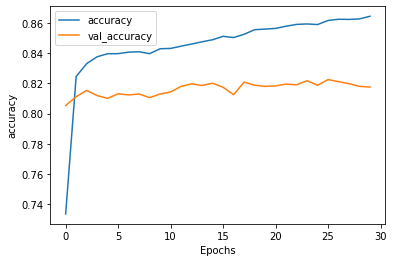

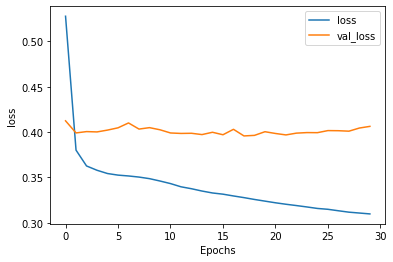

In [66]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])

  plt.savefig(string+'.png')
  plt.show()

  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [57]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV> ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [58]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(1000, 16)


In [59]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [60]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.39352304]
 [0.5094867 ]]


# Lesson 3

In [63]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.3.0


In [62]:
# If the import fails, run this
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJLCBK9/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJLCBK9/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJLCBK9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
print(tokenizer.subwords)

In [ ]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


In [ ]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [ ]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

In [ ]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')